## bert-base-uncased

L'ultimo modello non è tratto da Hugging Face, ma bensì si basa direttamente su BERT.

# Dataset

Rispetto ai due esempi precedenti, occorre modificare leggermente la classe RedditDataset

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizer
import pandas as pd
import torch

class RedditDataset(Dataset):
  """
    La classe RedditDataset si occupa di rappresentare il dataset che viene usato per l'addestramento, occupandosi anche della divisione tra Train, Test e Validation
  """

  def __init__(self, data : pd.DataFrame, tokenizer : PreTrainedTokenizer, split : str, max_length : int=128, scale : bool=False):
    """
      Costruttore della classe, che si occupa di caricare il file indicato dal parametro csv_file.
      Inoltre divide il dataset in Train (80%), Test (10%) e Validation (10%).

    PARAMETRI:
      data (DataFrame): datafreame contenente i dati del dataset, con le colonne 'clean_comment' e 'category'
      tokenizer (PreTrainedTokenizer): il tokenizer da usare per tokenizzare i commenti
      split (str): indica quale parte del dataset si vuole usare ('train', 'validation', 'test')
      max_length (int): lunghezza massima dei token (default 128)
      scale (bool): se True aumenta di uno le label del dataset (default False)
    """
    data.dropna(inplace=True)

    if len(data) == 0:
      raise ValueError("Dataset vuoto")

    if scale:
      data["category"] = data["category"] + 1

    train, temp_data = train_test_split(data, test_size=0.2, stratify=data["category"], random_state=42)
    validation, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data["category"], random_state=42)

    if split == 'train':
      selected_data = train
    elif split == 'validation':
      selected_data = validation
    elif split == 'test':
      selected_data = test
    else:
      raise ValueError("Il Parametro 'split' deve essere: 'train', 'validation' o 'test'")

    print(f"{split}: {set(selected_data['category'])}")

    self.encodings = tokenizer(selected_data["clean_comment"].tolist(), truncation=True, padding=True, max_length=max_length)
    self.labels = selected_data["category"].tolist()

  def __getitem__(self, idx : int) -> dict:
    """
      Restituisce un elemento del dataset in base all'indice passato come parametro.
    PARAMETRI:
      idx (int): indice dell'elemento da restituire
    RETURNS:
      dict: un dizionario contenente i token e le label dell'elemento richiesto
    """
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
    return item

  def __len__(self) -> int:
    """
      Restituisce la lunghezza del dataset.
    RETURNS:
      int: lunghezza del dataset
    """
    return len(self.labels)


# Modello

Per rapperesentare il modello è stata usata la classe SentimentClassifier

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import PreTrainedTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import AdamW
import seaborn as sns
import torch


class SentimentClassifier:

  def __init__(self):
    """
      Inizializza il modello di Sentiment Analysis, il tokenizer e il modello pre-addestrato.
      Il modello utilizzato è 'bert-base-uncased'.
    """
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

    self.train_losses = []
    self.train_accuracies = []
    self.eval_accuracies = []
    self.batch_checkpoints = []

  def get_tokenizer(self) -> PreTrainedTokenizer:
    """
      Restituisce il tokenizer utilizzato dal modello.
    RETURNS:
      PreTrainedTokenizer: il tokenizer utilizzato dal modello
    """
    return self.tokenizer

  def compute_accuracy(self, dataloader, device) -> float:
    """
      Calcola l'accuratezza del modello su un dataloader specificato.
    PARAMETRI:
      dataloader (DataLoader): il dataloader contenente i dati su cui calcolare l'accuratezza
      device (str): il dispositivo su cui eseguire il calcolo dell'accuratezza
    RETURNS:
      float: l'accuratezza del modello sui dati del dataloader
    """
    self.model.eval()
    self.model.to(device)
    true_labels = []
    predictions = []

    with torch.no_grad():
      for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

    return accuracy_score(true_labels, predictions)

  def evaluate(self, dataloader : DataLoader, device : str='cpu', confusion_matrix_path : str ="bert-base-uncased", label_names : list[str]=["Negativo", "Neutrale", "Positivo"], is_pre_finetuning : bool=True):
    """
      Valuta il modello sul dataloader passato come parametro.
    PARAMETRI:
      dataloader (DataLoader): il dataloader contenente i dati di test
      device (str): il dispositivo su cui eseguire la valutazione (default 'cpu')
      confusion_matrix_path (str): percorso in cui salvare la matrice di confusione
      label_names (list of str): nomi delle etichette per la matrice di confusione (default ["Negativo", "Neutrale", "Positivo"])
      is_pre_finetuning (bool): indica se il modello è pre-addestrato o fine-tuned (default True)
    """
    self.model.eval()
    self.model.to(device)

    predictions = []
    true_labels = []
    total_loss = 0.0
    total_steps = 0

    with torch.no_grad():
      for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        total_steps += 1

        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_steps
    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions, normalize='true')
    report = classification_report(true_labels, predictions, digits=4)

    print("Confusion Matrix:\n", cm)

    if label_names is not None:
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
      plt.xlabel("Predetto")
      plt.ylabel("Reale")
      plt.title("Confusion Matrix")
      plt.tight_layout()
      suffix = '-prefinetuning' if is_pre_finetuning else '-finetuned'
      plt.savefig(f"{confusion_matrix_path}{suffix}.png")
      plt.show()

    print("\nClassification Report:\n", report)

    print(f"eval_loss: {avg_loss:.4f}")
    print(f"eval_accuracy: {acc:.4f}")
    print(f"eval_f1: {f1:.4f}")


  def train(self, train_loader: DataLoader, eval_loader: DataLoader, device: str = "cpu", number_epoch: int = 3):
    """
      Addestra il modello sui dati del dataloader di addestramento e valuta su quello di validazione.
    PARAMETRI:
      train_loader (DataLoader): il dataloader contenente i dati di addestramento
      eval_loader (DataLoader): il dataloader contenente i dati di validazione
      device (str): il dispositivo su cui eseguire l'addestramento (default 'cpu')
      number_epoch (int): numero di epoche per l'addestramento (default 3)
    """
    self.model.train()
    self.model.to(device)
    batch_counter = 0

    for epoch in range(number_epoch):
      for batch in train_loader:
        self.optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        self.optimizer.step()

        batch_counter += 1

        if batch_counter % 500 == 0:
          train_acc = self.compute_accuracy(train_loader, device)
          eval_acc = self.compute_accuracy(eval_loader, device)

          self.train_accuracies.append(train_acc)
          self.eval_accuracies.append(eval_acc)
          self.train_losses.append(loss.item())
          self.batch_checkpoints.append(batch_counter)

          print(f"Batch {batch_counter}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}, Loss: {loss.item():.4f}")
          self.model.train()

      print(f"Epoch {epoch+1} completed.")

  def plot_metrics(self):
    """
      Plotta le metriche di addestramento e valutazione, inclusi la perdita e l'accuratezza.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.batch_checkpoints, self.train_losses, label="Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.batch_checkpoints, self.train_accuracies, label="Train Accuracy")
    plt.plot(self.batch_checkpoints, self.eval_accuracies, label="Eval Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

  def save(self, path):
    """
      Salva il modello e il tokenizer nel percorso specificato.

    PARAMETRI:
      path (str): Directory in cui salvare il modello e il tokenizer.
    """

    self.model.save_pretrained(path)
    self.tokenizer.save_pretrained(path)
    print(f"Modello e tokenizer salvati in: {path}")

# Addestramento

In questo script viene fatto l'addestramento della rete, con un Learning Rate pari a 5e-5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train: {0, 1, 2}
validation: {0, 1, 2}
test: {0, 1, 2}
Statistiche pre-fine tuning:
Confusion Matrix:
 [[0.28657799 0.00362757 0.70979444]
 [0.06666667 0.00306513 0.9302682 ]
 [0.26721415 0.00379027 0.72899558]]


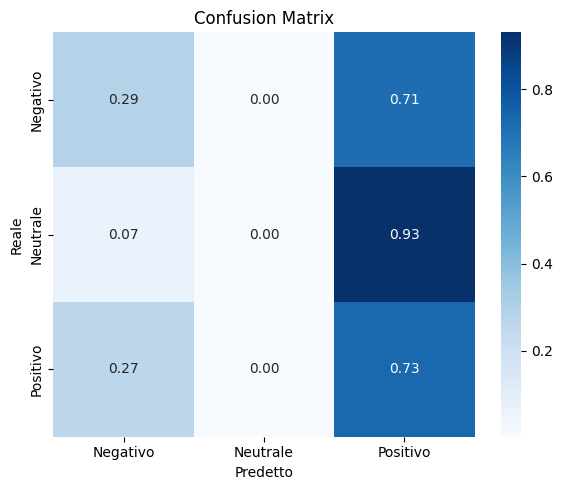


Classification Report:
               precision    recall  f1-score   support

           0     0.3173    0.2866    0.3011       827
           1     0.3077    0.0031    0.0061      1305
           2     0.3905    0.7290    0.5086      1583

    accuracy                         0.3755      3715
   macro avg     0.3385    0.3395    0.2719      3715
weighted avg     0.3451    0.3755    0.2859      3715

eval_loss: 1.0985
eval_accuracy: 0.3755
eval_f1: 0.2859
Inizio Adddestramento
Batch 500, Train Acc: 0.8098, Eval Acc: 0.7957, Loss: 0.2237
Batch 1000, Train Acc: 0.8558, Eval Acc: 0.8328, Loss: 0.1632
Batch 1500, Train Acc: 0.8963, Eval Acc: 0.8789, Loss: 0.4268
Batch 2000, Train Acc: 0.8838, Eval Acc: 0.8713, Loss: 0.0466
Batch 2500, Train Acc: 0.9110, Eval Acc: 0.8853, Loss: 0.9607
Batch 3000, Train Acc: 0.9251, Eval Acc: 0.9077, Loss: 0.0739
Batch 3500, Train Acc: 0.9330, Eval Acc: 0.9063, Loss: 0.7728
Epoch 1 completed.
Batch 4000, Train Acc: 0.9441, Eval Acc: 0.9203, Loss: 0.1966
Ba

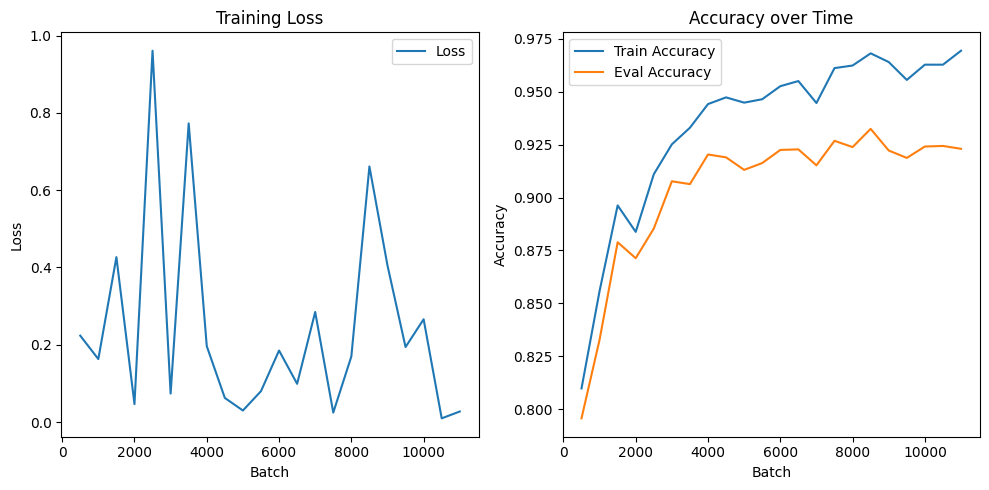

Fine Addestramento

Statistiche post-fine tuning:
Confusion Matrix:
 [[0.88633615 0.02055623 0.09310762]
 [0.01762452 0.95478927 0.02758621]
 [0.04295641 0.01137081 0.94567277]]


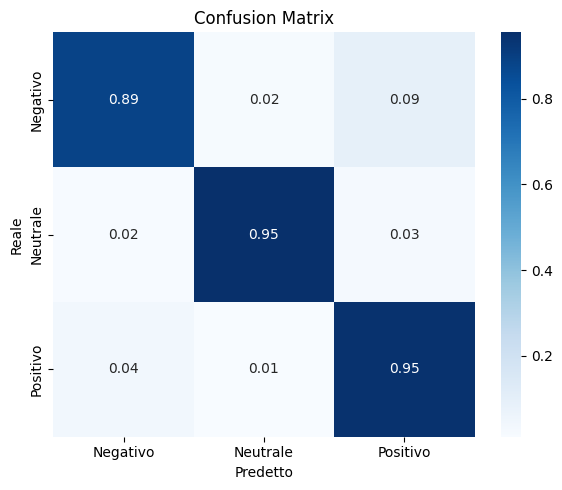


Classification Report:
               precision    recall  f1-score   support

           0     0.8896    0.8863    0.8879       827
           1     0.9727    0.9548    0.9637      1305
           2     0.9298    0.9457    0.9377      1583

    accuracy                         0.9357      3715
   macro avg     0.9307    0.9289    0.9298      3715
weighted avg     0.9359    0.9357    0.9357      3715

eval_loss: 0.2024
eval_accuracy: 0.9357
eval_f1: 0.9357

Statistiche Test:
Confusion Matrix:
 [[0.87681159 0.01811594 0.10507246]
 [0.01687117 0.96855828 0.01457055]
 [0.03600758 0.01010739 0.95388503]]


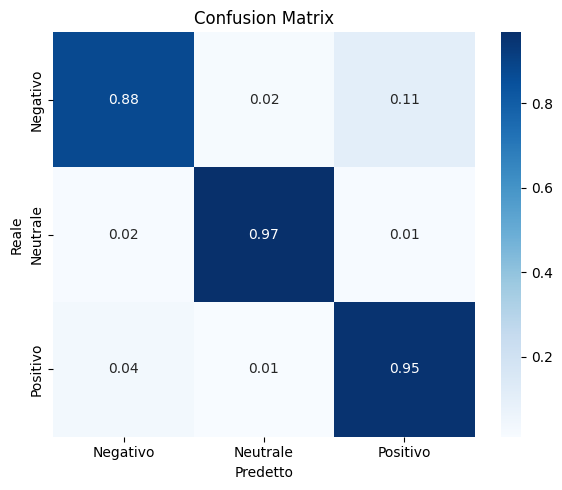


Classification Report:
               precision    recall  f1-score   support

           0     0.9019    0.8768    0.8892       828
           1     0.9760    0.9686    0.9723      1304
           2     0.9344    0.9539    0.9440      1583

    accuracy                         0.9419      3715
   macro avg     0.9374    0.9331    0.9352      3715
weighted avg     0.9418    0.9419    0.9417      3715

eval_loss: 0.1841
eval_accuracy: 0.9419
eval_f1: 0.9417
Modello e tokenizer salvati in: /content/drive/MyDrive/bert-base-uncased-ULTIMO


In [6]:
from google.colab import drive
drive.mount('/content/drive') #Per il salvataggio all'interno di Google Drive

import pandas as pd

data = pd.read_csv("./Reddit_Data.csv", on_bad_lines='skip')
data["category"] = data["category"]+1
classifier = SentimentClassifier()

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

train_dataset = RedditDataset(data, classifier.get_tokenizer(), split="train")
evaluetion_dataset = RedditDataset(data, classifier.get_tokenizer(), split="validation")
test_dataset = RedditDataset(data, classifier.get_tokenizer(), split="test")

print("Statistiche pre-fine tuning:")

val_dataloader = DataLoader(evaluetion_dataset, batch_size=8)
classifier.evaluate(val_dataloader, device=device, confusion_matrix_path="bert-base-uncased-ULTIMO", is_pre_finetuning=True)

print("Inizio Adddestramento")
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(evaluetion_dataset, batch_size=8)
classifier.train(train_dataloader, val_dataloader, device=device)
classifier.plot_metrics()
print("Fine Addestramento")

print("\nStatistiche post-fine tuning:")
val_dataloader = DataLoader(evaluetion_dataset, batch_size=8)
classifier.evaluate(val_dataloader, device=device, confusion_matrix_path="bert-base-uncased-ULTIMO", is_pre_finetuning=False)

print("\nStatistiche Test:")
test_dataloader = DataLoader(test_dataset, batch_size=8)
classifier.evaluate(test_dataloader, device=device, confusion_matrix_path="bert-base-uncased-test-ULTIMO")

classifier.save("/content/drive/MyDrive/bert-base-uncased-ULTIMO")

